# Notes on creating a generic particles reader/writer class

there's soemthing funky going on with references 

In [3]:
DATADIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/20181005-rib-TEM4/Extract/extract_one_2dclass/Micrographs'

In [4]:
import h5py
import glob
from os import path
import numpy as np
import mrcfile

In [32]:
def parse_particle_star( filepath ):
    with open(filepath, 'r') as f:
        keys = []
        for i in f.readlines():
            if i.startswith('_rln'):
                k = i.split()[0].replace('_rln','')
                keys.append(k)
            else:
                data = i.split()
                if len(data) == len(keys) and len(data) > 0:
                    out = {}
                    for n,k in enumerate(keys):
                        out[k] = data[n]
                        try:
                            if k not in ('ClassNumber',):
                                out[k] = float(data[n])
                        except:
                            pass
#                     print("  %s found: %s" % (i,out,))
                    yield out

def get_particle_image( mrcs ):
    with mrcfile.open(mrcs, permissive=True) as particles:
        # print( particles.data.shape )
        # mrcfile returns just a 2 dimensional matrix if only single image
        if len(particles.data.shape) == 2:
            yield particles.data
        else:
            for p in particles.data:
                yield p

def get_images( file_pattern, star_pattern ):
    for mrc in glob.glob( file_pattern ):
#         print("File: %s" % (mrc,))
        star_file = mrc.replace( *star_pattern )
        md = None
        if path.exists( star_file ):
            md = [ m for m in parse_particle_star( star_file ) ]
#         print(" meta: %s -> %s" % (star_file,len(md)))
        for i, p in enumerate( get_particle_image( mrc ) ):
            yield p, md[i] if md else None

            
def add_metadata( hf, path, meta, key, dtype=None ):
    klass = hf[path]
    klass.resize( (klass.shape[0]+1), axis=0 )
    if dtype:
        meta[key] = dtype(meta[key])
    klass[-1] = meta[key]
            
def create_particle_stack( output_file, file_pattern='./*.mrcs', star_pattern=('.mrcs', '_extract.star'), group_name='particles', image_name='images', parse_particle_star=True, first=None ):
    with h5py.File(output_file, 'w') as hf:
        string_dt = h5py.special_dtype(vlen=str)
        i = 0
        grp = hf.create_group(group_name)
        for p,meta in get_images( file_pattern, star_pattern ):
#             print( " got %s: %s (%s)" % (i,p.shape,meta) )
            if i == 0:
                grp.create_dataset(image_name, data=p[np.newaxis,...], maxshape=(None,p.shape[0],p.shape[1]), chunks=True)
                grp.create_dataset('class', data=np.asarray( [int(meta['ClassNumber']),] ),  maxshape=(None,), chunks=True, dtype='int8' )
                grp.create_dataset('ctf_resolution', data=np.asarray( [meta['CtfMaxResolution'],] ),  maxshape=(None,), chunks=True )
                grp.create_dataset('angle_psi', data=np.asarray( [meta['AnglePsi'],] ),  maxshape=(None,), chunks=True )
                grp.create_dataset('source_micrograph', data=np.array( [meta['MicrographName'],], dtype='S' ), maxshape=(None,), chunks=True, dtype=string_dt )
                grp.create_dataset('source_coordinates', data=np.array( [ ( meta['CoordinateX'], meta['CoordinateY'] ) ] ), maxshape=(None,2), chunks=True )

            else:
#                 print("P: %s" % (p,))
                images = hf['%s/%s' % (group_name,image_name)]
                images.resize( (images.shape[0]+1), axis=0 )
                images[-1] = p

                add_metadata( hf, 'particles/class', meta, 'ClassNumber', dtype=int)
                add_metadata( hf, 'particles/ctf_resolution', meta, 'CtfMaxResolution')
                add_metadata( hf, 'particles/angle_psi', meta, 'AnglePsi')                

                add_metadata( hf, 'particles/source_micrograph', meta, 'MicrographName', dtype=str)
                coords = hf['%s/%s' % (group_name,'source_coordinates')]
                coords.resize( (coords.shape[0]+1), axis=0 )
                coords[-1] =  [ ( meta['CoordinateX'], meta['CoordinateY'] ) ] 

            print( ".", end='')
            
            if first and i >= first - 1:
                break
            i = i+1


In [37]:
create_particle_stack( '/tmp/particles.hdf', file_pattern=DATADIR+"/*.mrcs", first=25 )

.........................

hmmm... all the images are the same... even though i'm using p.copy() above...

<HDF5 dataset "images": shape (25, 540, 540), type "<f4">
Particle #0: class 93 from Micrographs/Hasan_01692_aligned_DW.mrc@[1089.63996  3186.057024], res=3.232297 phi=-174.12814 
Particle #1: class 93 from Micrographs/Hasan_01692_aligned_DW.mrc@[2839.085608  236.38285 ], res=3.232297 phi=-61.62814 
Particle #2: class 93 from Micrographs/Hasan_01692_aligned_DW.mrc@[1897.999928 1627.891367], res=3.232297 phi=-129.12814 
Particle #3: class 93 from Micrographs/Hasan_00276_aligned_DW.mrc@[1224.125668  213.417136], res=3.053489 phi=62.121858 
Particle #4: class 93 from Micrographs/Hasan_00276_aligned_DW.mrc@[ 571.148549 2503.182764], res=3.053489 phi=-134.75314 
Particle #5: class 93 from Micrographs/Hasan_00276_aligned_DW.mrc@[1131.537101 1276.885665], res=3.053489 phi=-61.62814 
Particle #6: class 93 from Micrographs/Hasan_00827_aligned_DW.mrc@[2277.868486 2768.325611], res=3.040551 phi=157.746858 
Particle #7: class 93 from Micrographs/Hasan_03949_aligned_DW.mrc@[1647.857081 3107.331313]

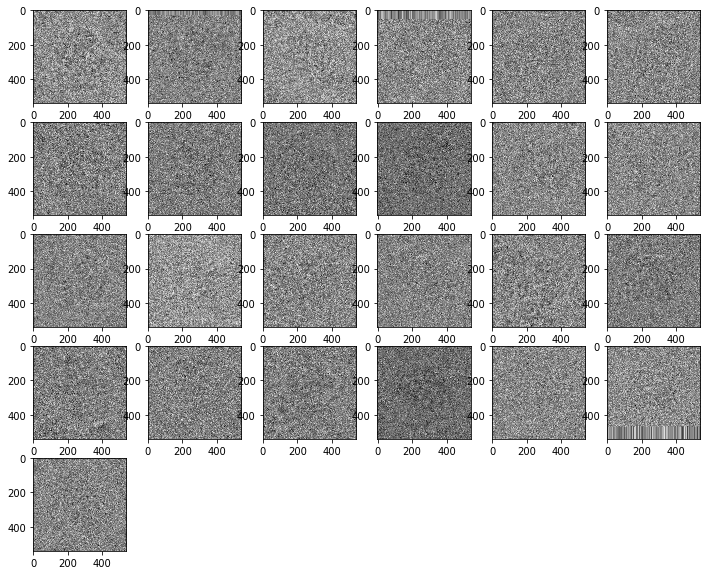

In [43]:
from matplotlib import pyplot as plt
with h5py.File( '/tmp/particles.hdf', 'r' ) as f:
    print( f['particles/images'] )
    fig = plt.figure(figsize=(12, 12))
    for i in range( f['particles/images'].shape[0] ):
        print( "Particle #%s: class %s from %s@%s, res=%s phi=%s " % (i, f['particles/class'][i], f['particles/source_micrograph'][i], f['particles/source_coordinates'][i], f['particles/ctf_resolution'][i], f['particles/angle_psi'][i] ) )
        fig.add_subplot( 6, 6, i+1 )
        plt.imshow( f['particles/images'][i], cmap='Greys' )
    plt.tight_layout()
    plt.show()